In [14]:
pip install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 17.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
DIR = '/kaggle/input/animefacedataset'
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])
# Create a Dataset object using your image directory and transforms
dataset = torchvision.datasets.ImageFolder(
    DIR,
    transform=transform
)
subset_size = 3000
subset_indices = torch.arange(subset_size)
subset = Subset(dataset, subset_indices)

# Create a DataLoader object to load batches of data  
train_dataset = DataLoader(
    subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3, 
    pin_memory=True
)

In [5]:
# Denorm to show images
def denorm(img):
    return img* stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=49):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    imd = denorm(images.detach()[:nmax])
    ax.imshow(make_grid(imd, nrow=7).permute(1, 2, 0))

def show_batch(dl, nmax=49):
    for images, _ in dl:
        show_images(images, nmax)
        break

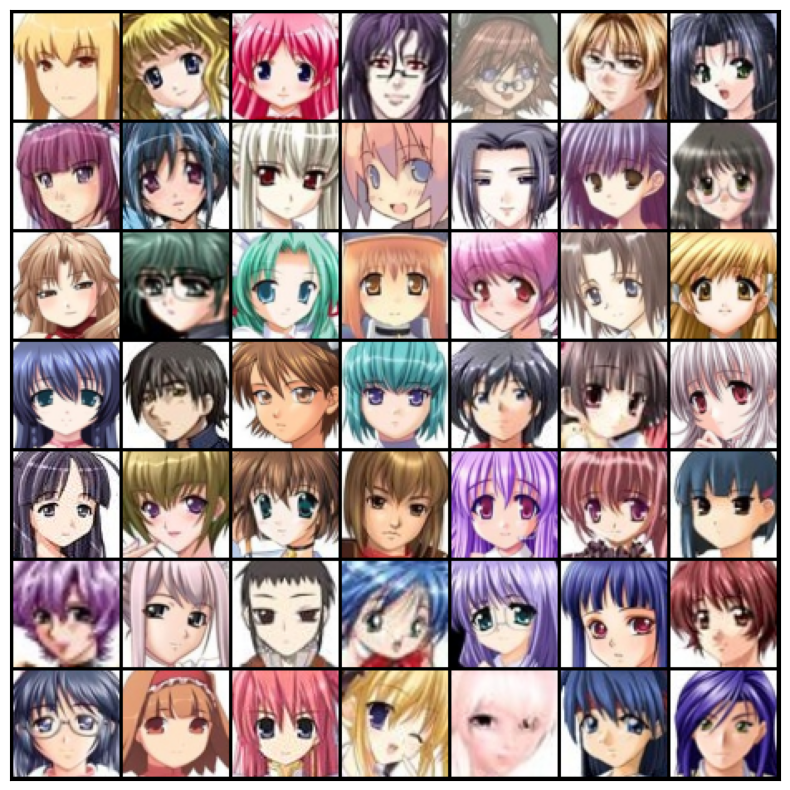

In [7]:
show_batch(train_dataset)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cpu')

In [10]:
train_dl = DeviceDataLoader(train_dataset, device)

In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, dtype=torch.float32).to(time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=False):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_channels)
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.1) if dropout else nn.Identity()
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_emb):
        time_emb = self.time_mlp(time_emb)[:, :, None, None]
        h = F.relu(self.conv1(x))
        h = h + time_emb
        h = F.relu(self.conv2(h))
        h = self.dropout(h)
        return h + self.residual_conv(x)  # Skip connection

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)  # Change Conv1d to Conv2d
        self.proj_out = nn.Conv2d(channels, channels, 1)  # Change Conv1d to Conv2d

    def forward(self, x):
        batch, c, h, w = x.shape
        x = x.view(batch, c, h * w)  # Flatten the spatial dimensions
        x = self.norm(x)

        qkv = self.qkv(x.view(batch, c, h, w))  # Apply Conv2d
        q, k, v = qkv.chunk(3, dim=1)

        q = q.softmax(dim=-1)
        attn = (q @ k.transpose(-1, -2)) * (c ** (-0.5))
        x = (attn @ v).reshape(batch, c, h, w)

        return self.proj_out(x.view(batch, c, h, w)) 

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_attn):
        super().__init__()
        self.resnet1 = ResNetBlock(in_channels, out_channels, time_emb_dim)
        self.attn = AttentionBlock(out_channels) if use_attn else nn.Identity()
        self.resnet2 = ResNetBlock(out_channels, out_channels, time_emb_dim)

    def forward(self, x, time_emb):
        x = self.resnet1(x, time_emb)
        x = self.attn(x)
        x = self.resnet2(x, time_emb)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_attn):
        super().__init__()
        self.resnet1 = ResNetBlock(in_channels, out_channels, time_emb_dim)
        self.attn = AttentionBlock(out_channels) if use_attn else nn.Identity()
        self.resnet2 = ResNetBlock(out_channels, out_channels, time_emb_dim)

    def forward(self, x, skip_x, time_emb):
        x = torch.cat([x, skip_x], dim=1)  # Concatenate the skip connection
        x = self.resnet1(x, time_emb)
        x = self.attn(x)
        x = self.resnet2(x, time_emb)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=256, base_channels=64):
        super().__init__()
        self.time_mlp = SinusoidalPositionEmbeddings(time_emb_dim)

        # Downsampling path
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down1 = DownBlock(base_channels, base_channels * 2, time_emb_dim, use_attn=False)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim, use_attn=True)
        self.down3 = DownBlock(base_channels * 4, base_channels * 8, time_emb_dim, use_attn=True)

        # Bottleneck
        self.bottleneck = ResNetBlock(base_channels * 8, base_channels * 16, time_emb_dim)

        # Upsampling path
        self.up1 = UpBlock(base_channels * 16 + base_channels * 8, base_channels * 8, time_emb_dim, use_attn=True)
        self.up2 = UpBlock(base_channels * 8 + base_channels * 4, base_channels * 4, time_emb_dim, use_attn=True)
        self.up3 = UpBlock(base_channels * 4 + base_channels * 2, base_channels * 2, time_emb_dim, use_attn=False)

        self.conv_out = nn.Conv2d(base_channels * 2, out_channels, kernel_size=1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)

        # Downsample
        x1 = F.relu(self.conv_in(x))
        x2 = self.down1(x1, t_emb)
        x3 = self.down2(x2, t_emb)
        x4 = self.down3(x3, t_emb)

        # Bottleneck
        x_bottleneck = self.bottleneck(x4, t_emb)

        # Upsample with skip connections
        x = self.up1(x_bottleneck, x4, t_emb)
        x = self.up2(x, x3, t_emb)
        x = self.up3(x, x2, t_emb)

        return self.conv_out(x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9851313..1.0277779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2613246..1.4836972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7222054..1.8797452].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0951188..2.311953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.335166..2.6195235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8539958..3.4376645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9198523.

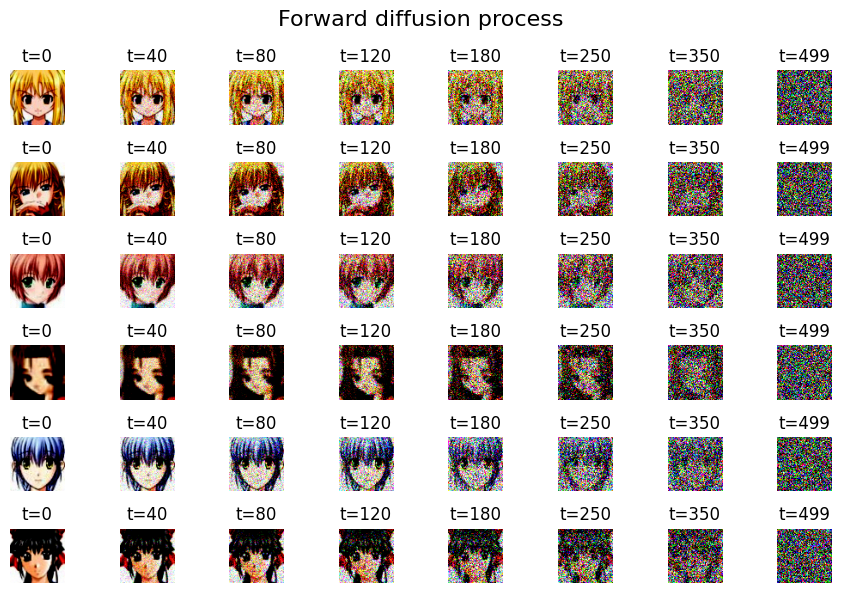

In [12]:
class CosineBetaSchedule:
    def __init__(self, T, s=0.008):
        self.T = T
        self.s = s
        self.betas = self.get_cosine_schedule(T)

    def get_cosine_schedule(self, T):
        steps = torch.linspace(0, T, T + 1)
        alphas = torch.cos(((steps / T) + self.s) / (1 + self.s) * np.pi / 2) ** 2
        alphas = alphas / alphas[0]  # Normalize
        betas = 1 - alphas[1:] / alphas[:-1]  
        return torch.clip(betas, 0.0001, 0.999)  

    def alpha_cumprod(self):
        return torch.cumprod(1 - self.betas, dim=0)  # Compute cumulative product of (1 - beta)

    def get_noise_schedule(self):
        alpha_cumprod = self.alpha_cumprod()
        return {
            "betas": self.betas,
            "alphas": 1 - self.betas,
            "alphas_cumprod": alpha_cumprod,
            "sqrt_alphas_cumprod": torch.sqrt(alpha_cumprod),
            "sqrt_one_minus_alphas_cumprod": torch.sqrt(1.0 - alpha_cumprod)
        }

# Forward Diffusion Process Function
def forward_diffusion_sample(x_0, t, noise_schedule, device):
    """Applies noise to the image at timestep t using the cosine noise schedule"""
    noise = torch.randn_like(x_0).to(device)  
    
    # Expand scalar tensors to match the image dimensions (batch_size, channels, height, width)
    sqrt_alpha_cumprod = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1, 1, 1).to(device)  
    sqrt_one_minus_alpha_cumprod = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1, 1, 1).to(device)  
    
    # Apply noise schedule to generate noisy images
    noisy_image = sqrt_alpha_cumprod * x_0 + sqrt_one_minus_alpha_cumprod * noise
    return noisy_image, noise

def reverse_process(model, x_T, noise_schedule, T):
    """Performs the reverse process to denoise and generate the image from pure noise."""
    x = x_T
    for t in range(T - 1, -1, -1):  # Go backwards from T to 0
        t_tensor = torch.tensor([t], device=x.device)
        predicted_noise = model(x, t_tensor)
        betas_t = noise_schedule['betas'][t]
        sqrt_recip_alphas_t = 1.0 / noise_schedule['sqrt_alphas_cumprod'][t]
        sqrt_one_minus_alpha_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t]

        # Compute the predicted mean (mu) for the reverse process
        posterior_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alpha_cumprod_t)
        
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(noise_schedule['betas'][t])
            x = posterior_mean + sigma_t * noise  # Sample from the posterior
        else:
            x = posterior_mean  # No noise at t=0
        
    return x

# Visualize Forward Diffusion Process (showing a few images at selected timesteps)
def visualize_forward_diffusion(x_0, noise_schedule, steps, device):
    fig, axes = plt.subplots(nrows=x_0.shape[0], ncols=len(steps), figsize=(9, 6))
    fig.suptitle("Forward diffusion process", fontsize=16)

    for i in range(x_0.shape[0]):  # Loop through each image in batch
        for j, t in enumerate(steps):
            noisy_image, _ = forward_diffusion_sample(x_0[i:i+1], t, noise_schedule, device)
            axes[i, j].imshow(noisy_image.squeeze().permute(1, 2, 0).cpu().numpy())
            axes[i, j].set_title(f't={t}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def run_diffusion_with_dataloader(train_dl, noise_schedule, device):
    batch = next(iter(train_dl))  # Get only one batch from the dataloader
    x_0 = to_device(batch[0], device)  # Move images to device

    x_0 = x_0[:6]  # Select a subset of images (change as needed)

    # Visualize diffusion at selected timesteps
    visualize_forward_diffusion(x_0, noise_schedule, timesteps, device)

# Set parameters
T = 500  
timesteps = [0, 40, 80, 120, 180, 250, 350, 499]  


cosine_schedule = CosineBetaSchedule(T)
noise_schedule = cosine_schedule.get_noise_schedule()

# Move noise_schedule to device
for key in noise_schedule:
    noise_schedule[key] = noise_schedule[key].to(device)

# Run diffusion process with real data
run_diffusion_with_dataloader(train_dl, noise_schedule, device)

In [13]:
# Mean Squared Error (MSE) loss function
criterion = nn.MSELoss()

def save_checkpoint(model, optimizer, epoch, filepath="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filepath)

def load_checkpoint(model, optimizer, filepath="checkpoint.pth"):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    return model, optimizer, start_epoch

# Main training function with checkpointing added
def train_diffusion_model(model, train_dl, optimizer, noise_schedule, num_epochs, T=500, device='cpu', checkpoint_path=None):
    """Train the diffusion model and print progress."""
    
    # Move noise_schedule values to the device
    for key in noise_schedule:
        noise_schedule[key] = noise_schedule[key].to(device)

    # For visualizing images at epoch 1 and final epoch
    images_at_first_epoch = None
    images_at_last_epoch = None

    model = to_device(model, device)  
    
    # If a checkpoint exists, load it
    start_epoch = 1
    if checkpoint_path:
        model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, num_epochs + 1):
        total_loss = 0
        model.train()

        # Wrap the DataLoader with tqdm for progress tracking
        with tqdm(train_dl, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch [{epoch}/{num_epochs}]")
            for batch in tepoch:
                x_0 = to_device(batch[0], device)  
                optimizer.zero_grad()

                # Random timestep for each image in the batch
                t = torch.randint(0, T, (x_0.shape[0],), device=device).long()

                # Generate noisy images and the corresponding noise
                noisy_images, true_noise = forward_diffusion_sample(x_0, t, noise_schedule, device)

                # Predict the noise with the model
                predicted_noise = model(noisy_images, t)

                # Compute the loss (MSE between predicted noise and true noise)
                loss = criterion(predicted_noise, true_noise)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Display current loss in tqdm progress bar
                tepoch.set_postfix(loss=loss.item())

                # Clear unused variables from memory to prevent out-of-memory issues
                torch.cuda.empty_cache()

        avg_loss = total_loss / len(train_dl)

        # Print epoch progress
        print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

        # Visualize images from the first and last epoch
        if epoch == 1:
            images_at_first_epoch = noisy_images.detach().cpu()
        elif epoch == num_epochs:
            images_at_last_epoch = noisy_images.detach().cpu()
        
        # Save checkpoint after each epoch
        save_checkpoint(model, optimizer, epoch, filepath="checkpoint.pth")

    return images_at_first_epoch, images_at_last_epoch


# Function to visualize images at different epochs
def visualize_images(images, title="Generated Images"):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    for i, img in enumerate(images):
        axes[i].imshow(img.permute(1, 2, 0).cpu().numpy())
        axes[i].axis('off')
    
    plt.show()

In [ ]:
num_epochs = 2  # Change based on how many epochs you want
learning_rate = 3e-4

# Initialize model, optimizer, and noise schedule
model = UNet()  # Assume the UNet class is already defined
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming train_dl is your data loader, you should already have it loaded
images_at_first_epoch, images_at_last_epoch = train_diffusion_model(
    model, train_dl, optimizer, noise_schedule, num_epochs, T, device
)

# Visualize the images at the first and last epoch
visualize_images(images_at_first_epoch[:6], title="Images from First Epoch")
visualize_images(images_at_last_epoch[:6], title="Images from Last Epoch")

Epoch [1/2]:   2%|▏         | 1/47 [01:07<51:30, 67.19s/batch, loss=1.05]

In [1]:
images_at_first_epoch, images_at_last_epoch = train_diffusion_model(
    model, train_dl, optimizer, noise_schedule, num_epochs=2, T=500, device, checkpoint_path="checkpoint.pth"
)

SyntaxError: positional argument follows keyword argument (3959660975.py, line 3)